In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import nonlinear_QM_FPJPA as Fs
import wx_programs as wx
import bnc
from generator import *
from hardware_config import *
from values import *
from qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
from analysis import *

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

q2.ro_amp = 0.2
# q2.ge_time = 98.9371236588114
# q2.ef_time = 130.05199911088016
# q2.ef_amp = 2.5
print(f"{q1}\n{q2}")

Qubit(ef_time=78.05067663337411, IQ_angle=240, ro_freq=6.7275, qubit_id=q1, ROq3=6.583064, ge_ssm=-0.11, RO_LO_pwr=16, ge_amp=1.2, ro_dur=5000, RO_LO=6.6247, qubit_thr=[-5000, 5000], ro_amp=0.5, ROIF=0.10280000000000022, ef_amp=1, ge_time=52.35258023759522, ef_ssm=-0.255)
Qubit(ef_time=None, IQ_angle=220, ro_freq=6.65555, qubit_id=q2, ROq3=6.583064, ge_ssm=-0.152, RO_LO_pwr=16, ge_amp=1.2, ro_dur=5000, RO_LO=6.6247, qubit_thr=[-5000, 5000], ro_amp=0.5, ROIF=0.030850000000000044, ef_amp=1, ge_time=40.15374412400174, ef_ssm=-0.224)
Qubit(ef_time=78.05067663337411, IQ_angle=240, ro_freq=6.7275, qubit_id=q1, ROq3=6.583064, ge_ssm=-0.11, RO_LO_pwr=16, ge_amp=1.2, ro_dur=5000, RO_LO=6.6247, qubit_thr=[-5000, 5000], ro_amp=0.5, ROIF=0.10280000000000022, ef_amp=1, ge_time=52.35258023759522, ef_ssm=-0.255)
Qubit(ef_time=None, IQ_angle=220, ro_freq=6.65555, qubit_id=q2, ROq3=6.583064, ge_ssm=-0.152, RO_LO_pwr=16, ge_amp=1.2, ro_dur=5000, RO_LO=6.6247, qubit_thr=[-5000, 5000], ro_amp=0.2, ROIF=0.

In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
num_steps = 101
reps = 500
sweep_time = 200

In [4]:
rabi.rabi_ef(q2, q1,gen_vals = general_vals_dict, num_steps = num_steps, sweep_time = sweep_time)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error


0, No error
0, No error
0, No error
Patterns: 101
Records per pattern: 500
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.689470 sec
Captured 17 buffers (2.541308 buffers per sec)
Captured 52224 records (7806.896727 records per sec)
Transferred 855638016 bytes (127908195.978528 bytes per sec)


<Figure size 800x800 with 0 Axes>

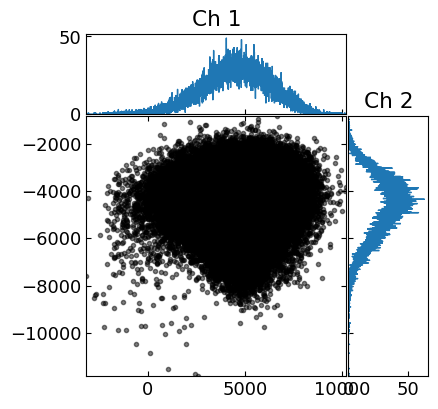

<Figure size 800x800 with 0 Axes>

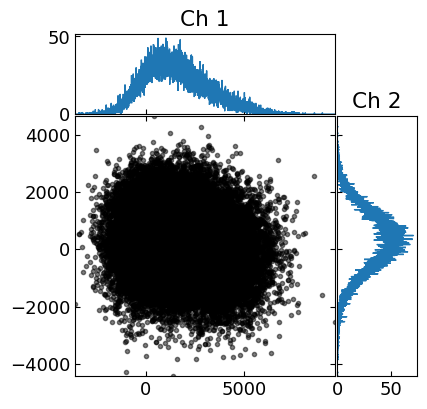

In [5]:
wx.wx_set_and_amplitude_and_offset(
    amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
)
values = daq.run_daq_het_2q(q1, q2,
                   num_patterns=num_steps, num_records_per_pattern=reps,
                    verbose=True)

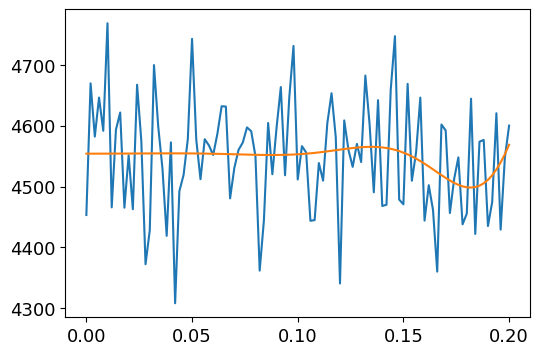



  freq: 10.647886681787135 +/- 4.277551117479049
 gamma: -34.28762132691303 +/- 42.744408368110875
   amp: 0.12324619401944827 +/- 0.919400266251026
 phase: -39.48982490029781 +/- 295.3103579071534
offset: 4554.100122004769 +/- 10.45504771117763
pi_pulse time: 0.046957674789611895 +/- 4.277551117479049
π_ge time = 46.95767478961189 ns


In [6]:
which_qubit = 1
if 1 == which_qubit:
    I_Q1 = values.rec_avg_vs_pats_1[0]
    Q_Q1 = values.rec_avg_vs_pats_1[1]
    I = I_Q1
    Q = Q_Q1
elif 2 == which_qubit:
    I_Q2 = values.rec_avg_vs_pats_2[0]
    Q_Q2 = values.rec_avg_vs_pats_2[1]
    I = I_Q2
    Q = Q_Q2
Qrange = abs(np.max(Q)-np.min(Q))
Irange = abs(np.max(I)-np.min(I))
if Qrange>Irange:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,Q,guess_vals=[11,0.3,np.abs(np.max(Q)-np.min(Q)),38,Q[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,I,guess_vals=[11,0.3,np.abs(np.max(I)-np.min(I)),38,I[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
    
